# Analyse en Composantes Principales (ACP) appliquée au marché pétrolier

##  Objectif
Ce notebook se concentre exclusivement sur l'utilisation de l'Analyse en Composantes Principales (ACP)
pour extraire des facteurs latents à partir de variables du marché pétrolier. L'objectif est de comprendre
les dynamiques communes entre ces indicateurs afin d'expliquer les variations hebdomadaires du prix du WTI.

---

##  1. Chargement et préparation des données

- Chargement du fichier Excel contenant les données.
- Création du ratio Future/Spot.
- Vérification des valeurs nulles ou aberrantes.
- Affichage initial des données.

---

##  2. Transformation des variables pour assurer la stationnarité

- Transformation logarithmique et différentiation des variables suivantes :
  - Open Interest
  - Ratio Future/Spot
  - OVX (si nécessaire)
- Test ADF (Augmented Dickey-Fuller) pour vérifier la stationnarité.

---

##  3. Nettoyage et standardisation des variables

- Sélection des variables transformées (stationnaires).
- Suppression des valeurs manquantes.
- Standardisation avec `StandardScaler` (moyenne 0, écart-type 1).

---

##  4. Application de l'ACP

- Application de la PCA avec `sklearn`.
- Analyse de la variance expliquée.
- Interprétation des composantes principales (loadings).
- Sélection du nombre optimal de composantes.

---

##  5. Interprétation des facteurs extraits

- Analyse des coefficients de chaque composante.
- Données économiques associées à chaque facteur :
  - PC1 = Sentiment de marché (stress, volatilité, spéculation)
  - PC2 = Activité ou profondeur du marché (Open Interest)
- Visualisation possible de l’évolution temporelle de PC1 et PC2.

---

##  6. Utilisation des composantes principales

- Ajout des scores PC1 et PC2 au DataFrame principal.
- Optionnel : corrélation avec les rendements du WTI.
- Préparation d'une future modélisation si souhaitée (hors de ce notebook).

---

##  Conclusion

L'ACP permet de réduire la complexité du système en extrayant des facteurs économiquement interprétables.
Dans le contexte du marché pétrolier, elle met en évidence deux dimensions dominantes :
1. Le sentiment ou la volatilité du marché.
2. L’intensité de l’activité du marché via l’Open Interest.

Ces résultats pourront alimenter une modélisation économétrique ultérieure du WTI.


Importation des données

In [ ]:
# 📚 Importation des bibliothèques essentielles
import numpy as np                  # pour les calculs numériques
import pandas as pd                 # pour la manipulation des données
import matplotlib.pyplot as plt     # pour les graphiques
import seaborn as sns               # pour les visualisations avancées
import statsmodels.api as sm        # pour les modèles économétriques
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler  # standardisation
from sklearn.decomposition import PCA             # pour l’ACP
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats             # tests statistiques (normalité, etc.)
from google.colab import files      # pour le téléversement des fichiers
import io



#  Chargement du fichier Excel
print("Veuillez téléverser le fichier 'Indicateurs financier_Petrole_WTI_2010-2025_final.xlsx'")
uploaded_WTI = files.upload()

#  Lecture du fichier Excel (et non CSV)
filename_WTI = list(uploaded_WTI.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded_WTI[filename_WTI]))


# 🧮 Création du ratio Future/Spot
df['ratio_futur_spot'] = df['Futures_Price_WTI_USD'] / df['WTI_Spot_Price_USD']

# Aperçu
df.head()

Veuillez téléverser le fichier 'Indicateurs financier_Petrole_WTI_2010-2025_final.xlsx'


Saving WTI_data_final.xlsx to WTI_data_final.xlsx


,Date,WTI_Spot_Price_USD,Futures_Price_WTI_USD,Open Interest_nub,OVX,Positions_Long_hedge Fund,Positions_short_hedge Fund,Net_Position_Hedge_Fund,ratio_futur_spot
0,2010-01-01,79.07,82.75,1231436,31.34,194643,39868,154775,1.046541
1,2010-01-08,82.34,78.00,1300867,29.80,217292,41673,175619,0.947292
2,2010-01-15,80.06,74.54,1324903,34.85,214738,37734,177004,0.931052
3,2010-01-22,76.62,72.89,1320661,34.05,179142,45987,133155,0.951318
4,2010-01-29,73.94,71.19,1360697,39.99,169012,47938,121074,0.962808


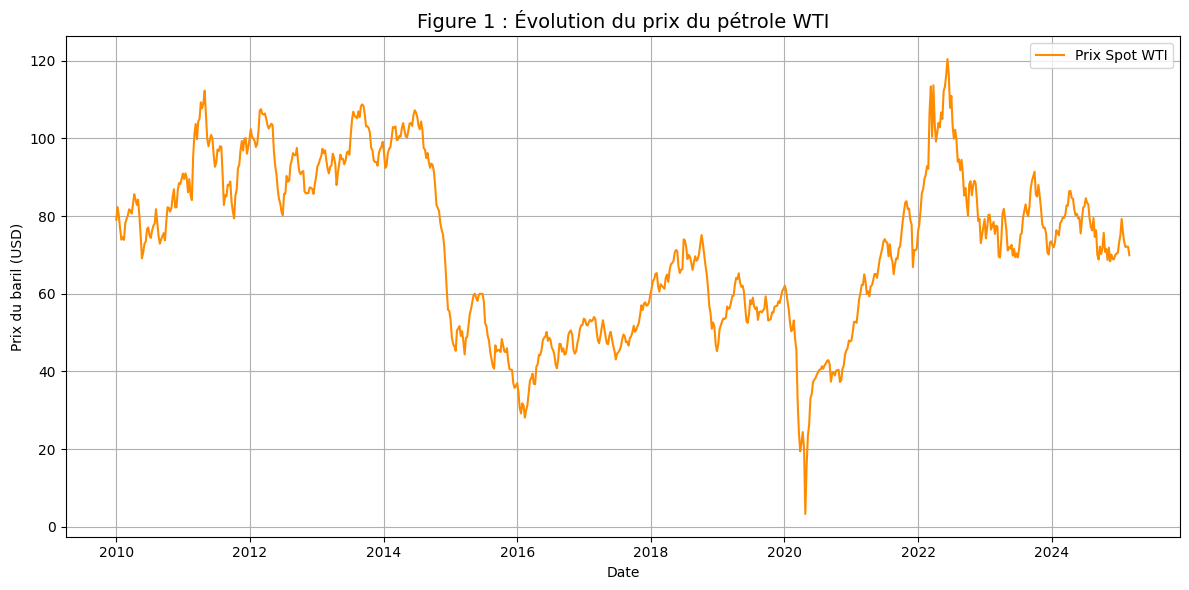

In [ ]:
# Tracer le prix du pétrole WTI en fonction du temps
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['WTI_Spot_Price_USD'], label='Prix Spot WTI', color='darkorange')
plt.title('Figure 1 : Évolution du prix du pétrole WTI', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Prix du baril (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#**2.Transformation des variables pour stationnarité**

In [ ]:
from statsmodels.tsa.stattools import adfuller

#  On évite les logs de valeurs nulles ou négatives
df["Open Interest_nub"] = df["Open Interest_nub"].replace(0, np.nan)
df["OVX"] = df["OVX"].replace(0, np.nan)

#  Transformation log + différenciation
df["Log_Delta_OI"] = np.log(df["Open Interest_nub"]).diff()
df["Log_Delta_Ratio"] = np.log(df['ratio_futur_spot']).diff()

#  Fonction de test ADF
def test_stationarite(serie, nom):
    result = adfuller(serie.dropna())
    print(f"\n🔍 Test ADF pour {nom}")
    print(f"Statistique : {result[0]:.4f}")
    print(f"p-value     : {result[1]:.4f}")
    if result[1] < 0.05:
        print("✅ Stationnaire")
    else:
        print("❌ Non stationnaire")

# Tests
test_stationarite(df["Log_Delta_OI"], "Log Δ Open Interest")
test_stationarite(df["Log_Delta_Ratio"], "Log Δ Ratio Future/Spot")
test_stationarite(df["Net_Position_Hedge_Fund"], "Net Position")
test_stationarite(df["OVX"], "OVX")



🔍 Test ADF pour Log Δ Open Interest
Statistique : -5.7414
p-value     : 0.0000
✅ Stationnaire

🔍 Test ADF pour Log Δ Ratio Future/Spot
Statistique : -10.6195
p-value     : 0.0000
✅ Stationnaire

🔍 Test ADF pour Net Position
Statistique : -4.8573
p-value     : 0.0000
✅ Stationnaire

🔍 Test ADF pour OVX
Statistique : -5.7325
p-value     : 0.0000
✅ Stationnaire


#**3.Nettoyage et standardisation des variables**

###  Objectif de cette section

Avant d'appliquer l'Analyse en Composantes Principales (ACP), nous devons :

1. **Construire une matrice de données \( X \)** contenant les variables explicatives que l'on soupçonne de partager des dynamiques communes liées aux mouvements du WTI.
2. **S’assurer que ces variables sont stationnaires** (transformées au besoin).
3. **Standardiser les données** : l'ACP étant sensible à l'échelle des variables, on applique une standardisation (centrage-réduction) pour que toutes les variables aient une moyenne de 0 et un écart-type de 1.

---

###  Construction de la matrice \( X \)

Nous sélectionnons les variables suivantes :
- `Log_Delta_OI` : variation log de l’Open Interest (activité globale sur les contrats à terme)
- `Log_Delta_Ratio` : variation log du ratio Future/Spot (structure du marché à terme)
- `Net_Position_Hedge_Fund` : position nette des spéculateurs (sentiment spéculatif)
- `OVX` : indice de volatilité implicite du marché pétrolier (mesure du risque perçu)

Ces variables sont ensuite nettoyées des valeurs manquantes, puis standardisées avant d’être utilisées comme entrée de l’ACP.

In [ ]:
from sklearn.preprocessing import StandardScaler

# ✅ Sélection des variables transformées et stationnaires

df_pca = pd.DataFrame()

df_pca["Log_Delta_OI"] = df["Log_Delta_OI"]
df_pca["Log_Delta_Ratio"] = df["Log_Delta_Ratio"]
df_pca["Net_Position"] = df["Net_Position_Hedge_Fund"]
df_pca["OVX"] = df["OVX"]

# 🔎 Suppression des lignes avec valeurs manquantes
df_pca = df_pca.dropna()

# ⚖️ Standardisation des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# Vérification des dimensions
print("Matrice standardisée - dimensions :", X_scaled.shape)

Matrice standardisée - dimensions : (791, 4)


##**4. Application de l'Analyse en Composantes Principales (ACP)**


### Objectif

L’objectif est maintenant d’appliquer une Analyse en Composantes Principales (ACP) à la matrice \( X \)
standardisée construite précédemment. L’ACP va nous permettre de :

- Réduire la dimensionnalité du jeu de données tout en conservant l’essentiel de l’information.
- Identifier des **facteurs latents** qui résument les dynamiques communes entre les indicateurs.
- Faciliter l’interprétation économique du comportement du marché pétrolier à travers des composantes synthétiques.

### Logique

- Les **valeurs propres** associées à chaque composante.
- La **proportion de variance expliquée** par chaque composante.
- Les **poids (loadings)** de chaque variable dans chaque composante principale.
- Les **scores** (valeurs des composantes principales) pour chaque semaine.

Ces résultats serviront à interpréter les facteurs latents (PC1, PC2, etc.) et à les intégrer dans des analyses ultérieures.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Sélection des variables stationnaires
X_vars = df_pca[[  # Tu peux garder df_pca ici si tu veux
    'Log_Delta_OI',
    'Log_Delta_Ratio',
    'Net_Position',
    'OVX'
]].dropna()

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vars)

# PCA avec 4 composantes (capture 100 % de la variance)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Affichage des variances expliquées
print("✅ Variance expliquée par chaque composante :", pca.explained_variance_ratio_)
print("📊 Variance cumulée :", np.sum(pca.explained_variance_ratio_))

# Loadings (coefficients des composantes)
loadings = pd.DataFrame(
    pca.components_,
    columns=X_vars.columns,
    index=["PC1", "PC2", "PC3", "PC4"]
)
print("📚 Loadings (poids des variables) :")
display(loadings)

# Ajout des 4 PC au DataFrame principal
df = df.iloc[-len(X_pca):].copy()  # Assure l'alignement
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]
df['PC3'] = X_pca[:, 2]
df['PC4'] = X_pca[:, 3]


✅ Variance expliquée par chaque composante : [0.30234371 0.25218046 0.2389701  0.20650572]
📊 Variance cumulée : 1.0
📚 Loadings (poids des variables) :


,Log_Delta_OI,Log_Delta_Ratio,Net_Position,OVX
PC1,-0.140522,0.385716,-0.639047,0.650458
PC2,0.885202,-0.350209,-0.280126,0.123694
PC3,0.423111,0.853228,0.154181,-0.263073
PC4,0.132845,0.024067,0.699554,0.701710


# **5. Interprétation des composantes principales**

### PC1 – Sentiment de marché et volatilité spéculative

La première composante principale (**PC1**) est une combinaison linéaire des quatre variables analysées, mais elle est principalement influencée par :

- une contribution positive importante de l’indice de volatilité **OVX** (+0.650),
- une contribution négative marquée de la **position nette des hedge funds** (-0.639),
- une contribution modérée du **ratio Future/Spot** (+0.386).

Cela suggère que PC1 capte un facteur de **stress spéculatif** ou de **nervosité du marché**. Lorsque la volatilité perçue (OVX) augmente et que les hedge funds réduisent leurs positions longues nettes, cette composante a tendance à croître. PC1 reflète donc des dynamiques de risque perçu et de désengagement spéculatif caractéristiques d’un climat incertain sur les marchés pétroliers.

---

### PC2 – Activité et engagement du marché

La deuxième composante principale (**PC2**) est dominée par une très forte contribution positive de la **variation de l’Open Interest** (+0.885), qui reflète l’évolution du volume de contrats ouverts sur le marché. Les autres variables ont un poids beaucoup plus faible.

PC2 capte ainsi un **facteur d’activité de marché** : une hausse de l’Open Interest est généralement interprétée comme une intensification de la participation des acteurs économiques, que ce soit à des fins de couverture ou de spéculation. Cette composante peut donc être interprétée comme un indicateur d’engagement ou de profondeur de marché.

---

### PC3 – Dynamique du ratio Future/Spot

La troisième composante principale (**PC3**) est fortement influencée par le **ratio Future/Spot** (+0.853), avec une contribution positive secondaire de l’Open Interest (+0.423). Elle reflète essentiellement les mouvements relatifs entre les prix futurs et les prix au comptant du pétrole.

Cette composante peut être interprétée comme un **facteur de positionnement anticipatif** ou d’**attentes sur les prix futurs**, dans la mesure où un ratio élevé peut signaler une prime à terme importante.

---

### PC4 – Intensité combinée des positions et de la volatilité

La quatrième composante principale (**PC4**) est dominée par deux contributions positives : la **position nette des hedge funds** (+0.700) et l’**indice OVX** (+0.701). Contrairement à PC1 où Net_Position et OVX évoluaient en sens inverse, ici les deux variables bougent dans le même sens.

PC4 semble ainsi capter une **intensité commune de positionnement et de volatilité**, qui pourrait indiquer une phase de repositionnement stratégique des grands intervenants dans un contexte de forte incertitude.

---

### Résumé des interprétations

| Composante | Signification économique | Variables dominantes |
|------------|--------------------------|-----------------------|
| **PC1**    | Stress de marché / volatilité spéculative | + OVX, – Net_Position |
| **PC2**    | Activité / engagement du marché | + Log_Delta_OI |
| **PC3**    | Anticipations de prix / ratio Future-Spot | + Log_Delta_Ratio |
| **PC4**    | Intensité des positions dans un contexte volatil | + Net_Position, + OVX |

Ces quatre composantes principales synthétisent les dynamiques clés du marché pétrolier et serviront de base à l’analyse prédictive des rendements hebdomadaires du WTI.


# **6. Régression linéaire des rendements du WTI sur les composantes principales**

Maintenant que nous avons extrait les quatre composantes principales (PC1 à PC4), nous allons :

- Calculer les **rendements hebdomadaires du prix spot du WTI** (log-returns),
- Étudier leur **corrélation** avec les composantes principales,
- Estimer une **régression linéaire** afin de mesurer l’effet de ces facteurs latents sur la variation du WTI.

---

### Formulation du modèle économétrique

Nous modélisons les rendements hebdomadaires du prix spot du baril WTI selon l’équation suivante :

$$
\text{RWTI}_t = \alpha + \beta_1 \cdot \text{PC1}_t + \beta_2 \cdot \text{PC2}_t + \beta_3 \cdot \text{PC3}_t + \beta_4 \cdot \text{PC4}_t + \varepsilon_t
$$

où :

- $\text{RWTI}_t$ est le **log-rendement hebdomadaire** du prix spot du WTI,
- $\text{PC1}_t$ à $\text{PC4}_t$ sont les **composantes principales** extraites à partir des variables explicatives,
- $\alpha$ est une constante (interception),
- $\varepsilon_t$ est un terme d’erreur (résidu).

---

L’objectif est d’évaluer si ces composantes principales ont une **influence significative** sur les variations hebdomadaires du marché pétrolier, et si elles permettent d’en améliorer la **prédictibilité hors échantillon**.


In [ ]:
# Calcul du rendement logarithmique hebdomadaire du prix spot du WTI
df['WTI_log_return'] = np.log(df['WTI_Spot_Price_USD']).diff()

# Affichage des dernières lignes pour vérification
df[['Date', 'WTI_Spot_Price_USD', 'WTI_log_return']].tail()


# Création du DataFrame df_reg contenant le rendement et les 4 composantes principales
df_reg = df[['WTI_log_return', 'PC1', 'PC2', 'PC3', 'PC4']].dropna()

# Affichage de la dimension et d'un aperçu du jeu de données
print("Dimensions du jeu de régression :", df_reg.shape)
df_reg.head()

Dimensions du jeu de régression : (790, 5)


,WTI_log_return,PC1,PC2,PC3,PC4
2,-0.028081,0.006886,0.766133,0.129801,-0.249170
3,-0.043918,0.546429,0.022806,0.020684,-0.732035
4,-0.035604,0.663044,1.287505,0.372804,-0.390132
5,0.008484,1.186021,-1.127589,-0.613309,-1.178594
6,-0.009296,0.891673,-0.182536,0.458423,-0.798940


**Corrélation entre PC1 / PC2 et le rendement**

In [ ]:
print("📌 Corrélation entre les composantes et le rendement du WTI :")
display(df_reg.corr())

📌 Corrélation entre les composantes et le rendement du WTI :


,WTI_log_return,PC1,PC2,PC3,PC4
WTI_log_return,1.000000,-0.459168,0.276314,-0.701599,-0.042695
PC1,-0.459168,1.000000,0.001807,0.000131,-0.000276
PC2,0.276314,0.001807,1.000000,-0.000472,0.000993
PC3,-0.701599,0.000131,-0.000472,1.000000,0.000072
PC4,-0.042695,-0.000276,0.000993,0.000072,1.000000


**Régression linéaire (OLS)**

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df_reg[['PC1', 'PC2','PC3','PC4']])  # const pour l'intercept α
y = df_reg['WTI_log_return']

model = sm.OLS(y, X).fit()

# Résumé des résultats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         WTI_log_return   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     701.8
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          1.76e-257
Time:                        00:11:47   Log-Likelihood:                 1330.5
No. Observations:                 790   AIC:                            -2651.
Df Residuals:                     785   BIC:                            -2628.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.067      0.9

## Analyse des résultats de la régression linéaire

Nous avons estimé une régression linéaire du type :

$$
\text{RWTI}_{t} = \alpha + \beta_1 \cdot \text{PC1}_t + \beta_2 \cdot \text{PC2}_t + \beta_3 \cdot \text{PC3}_t + \beta_4 \cdot \text{PC4}_t + \varepsilon_t
$$

---

### Résultats du modèle OLS

- **\( R^2 = 0.781 \)** : le modèle explique environ **78 % de la variance** du rendement hebdomadaire du WTI, ce qui représente une amélioration substantielle par rapport au modèle à deux composantes.
- Tous les coefficients des composantes principales sont **statistiquement significatifs** (p-value < 0.05), à l’exception de l’intercept :
  - \( $\beta_1$ = -0.0401 \) : PC1 a un effet **négatif fort**, cohérent avec une hausse du stress spéculatif.
  - \( $\beta_2$ = +0.0266 \) : PC2 a un effet **positif net**, lié à l’activité de marché.
  - \( $\beta_3$ = -0.0689 \) : PC3 a un **effet négatif marqué**, suggérant que des anticipations sur le ratio future/spot peuvent exercer une pression baissière.
  - \( $\beta_4 = -0.0045$ \) : PC4 a un **effet légèrement négatif**, mais significatif, potentiellement lié à un repositionnement prudent dans des phases volatiles.
- L’intercept ( $\alpha \$) n’est pas significatif, ce qui est fréquent pour des séries de rendements centrées.

---

### Interprétation économique

- **PC1 (stress spéculatif / volatilité)** exerce une influence **fortement négative** : les périodes de nervosité sur le marché sont associées à une baisse des rendements du WTI.
- **PC2 (activité / Open Interest)** a un **effet positif clair**, traduisant l’impact favorable d’un engagement accru des acteurs de marché.
- **PC3 (anticipation via ratio futur/spot)** est fortement négatif, indiquant que lorsque ce ratio augmente, les rendements sont généralement en baisse.
- **PC4 (positions spéculatives dans un contexte volatil)** montre un effet négatif plus modéré mais significatif.

---

### Bilan de l'approche factorielle ACP appliquée aux rendements pétroliers

Ce modèle valide l’intérêt d’utiliser plusieurs composantes principales extraites via ACP pour expliquer les variations du prix du pétrole. Il démontre qu’une combinaison de facteurs liés au sentiment, à l’activité, à la structure des prix et aux positions de marché permet une meilleure explication des dynamiques hebdomadaires du WTI.

Ces résultats encouragent l’exploration de modèles économétriques plus avancés (par exemple, modèles ARMA-GARCH avec variables exogènes) ou l’introduction de structures dynamiques dans les composantes.


## **7. Visualisation graphique des relations entre composantes principales et rendements**

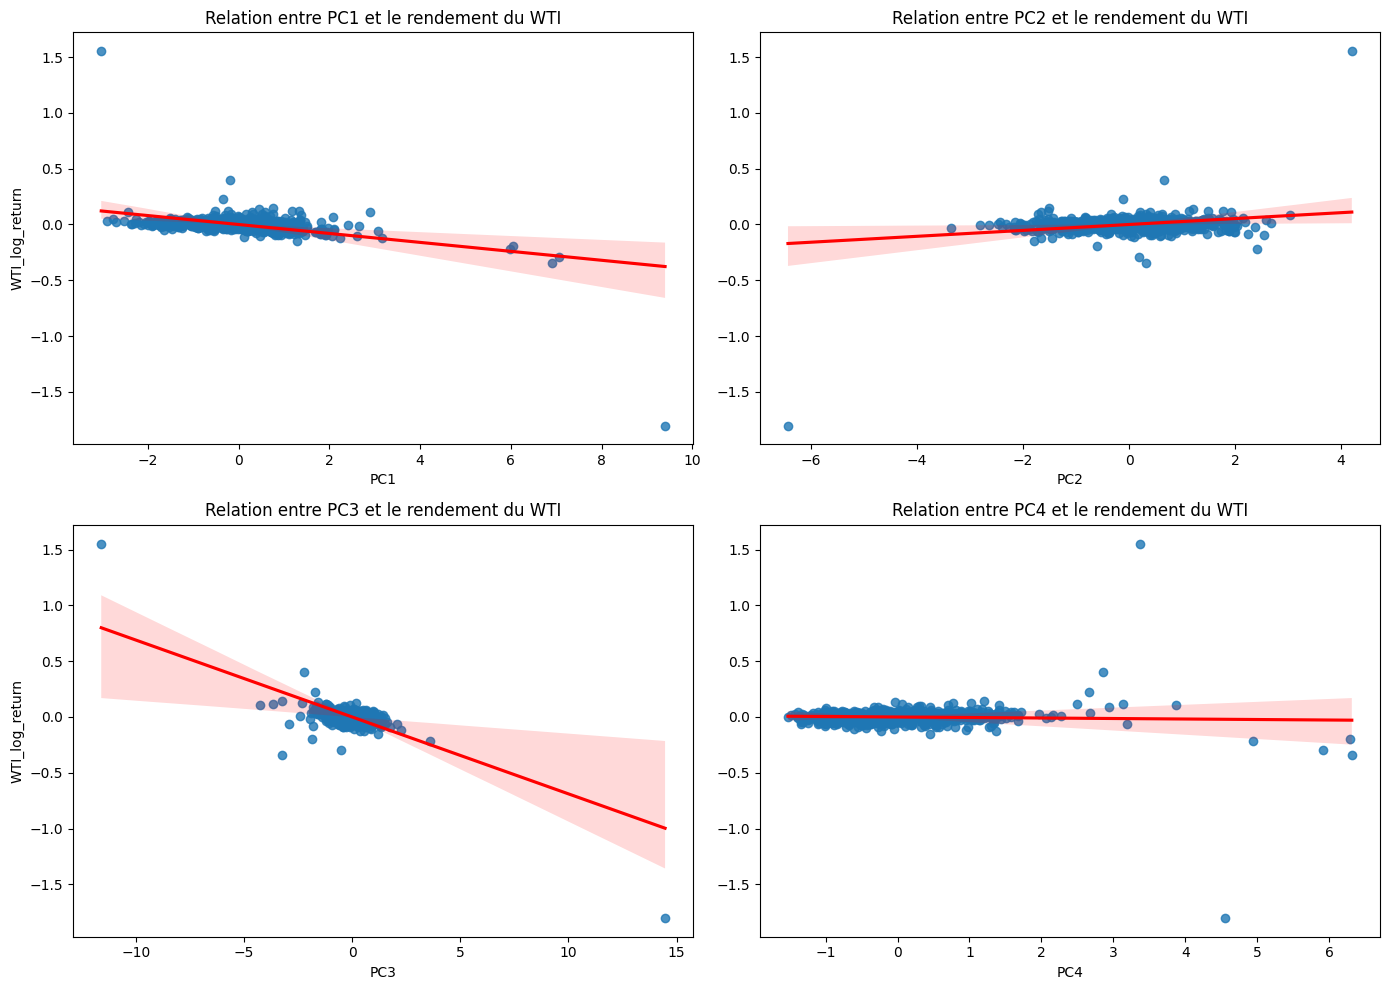

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))

# PC1 vs WTI return
plt.subplot(2, 2, 1)
sns.regplot(x='PC1', y='WTI_log_return', data=df_reg, line_kws={"color": "red"})
plt.title("Relation entre PC1 et le rendement du WTI")
plt.xlabel("PC1")
plt.ylabel("WTI_log_return")

# PC2 vs WTI return
plt.subplot(2, 2, 2)
sns.regplot(x='PC2', y='WTI_log_return', data=df_reg, line_kws={"color": "red"})
plt.title("Relation entre PC2 et le rendement du WTI")
plt.xlabel("PC2")
plt.ylabel("")

# PC3 vs WTI return
plt.subplot(2, 2, 3)
sns.regplot(x='PC3', y='WTI_log_return', data=df_reg, line_kws={"color": "red"})
plt.title("Relation entre PC3 et le rendement du WTI")
plt.xlabel("PC3")
plt.ylabel("WTI_log_return")

# PC4 vs WTI return
plt.subplot(2, 2, 4)
sns.regplot(x='PC4', y='WTI_log_return', data=df_reg, line_kws={"color": "red"})
plt.title("Relation entre PC4 et le rendement du WTI")
plt.xlabel("PC4")
plt.ylabel("")

plt.tight_layout()
plt.show()


### Rappel géométrique sur les axes factoriels

Dans une Analyse en Composantes Principales (ACP), les nouvelles composantes (PC1 à PC4 dans notre cas) sont obtenues en projetant les données sur de nouveaux axes orthogonaux, appelés axes factoriels.

Ces axes sont issus des vecteurs propres de la matrice de covariance (ou de corrélation) des données standardisées, ordonnés par ordre décroissant de valeur propre (variance expliquée) :

- **PC1** est la direction expliquant la plus grande part de la variance.
- **PC2** est la direction orthogonale à PC1 qui explique la variance résiduelle maximale.
- **PC3** et **PC4** prolongent ce processus pour capturer les dimensions restantes.

Chaque axe est une combinaison linéaire des variables initiales, et leurs poids sont donnés par les **loadings**. Ces nouvelles dimensions sont utiles pour réduire la complexité tout en conservant l’essentiel de l'information économique.

---

### Visualisation des relations entre les composantes principales et le rendement du WTI

Les quatre graphiques ci-dessus montrent la relation linéaire entre chaque composante principale et le rendement hebdomadaire du WTI :

- **PC1** (stress spéculatif et volatilité) :  
  La pente négative indique qu'une augmentation du stress perçu ou de l’incertitude est généralement associée à une baisse du rendement du WTI.

- **PC2** (activité du marché via Open Interest) :  
  La pente légèrement positive reflète un lien modéré entre l’engagement des acteurs sur les marchés à terme et une hausse des rendements.

- **PC3** (anticipations de prix à travers le ratio Future/Spot) :  
  La relation négative est marquée, ce qui suggère que certaines configurations de prix à terme anticipent des rendements baissiers.

- **PC4** (positions spéculatives dans un contexte volatil) :  
  La pente légèrement négative traduit une dynamique plus nuancée, possiblement liée à des ajustements prudents de position dans des marchés incertains.

---

Ces visualisations confirment les résultats de la régression linéaire et renforcent l'interprétation économique de chacune des composantes. Elles illustrent visuellement comment chaque facteur synthétique est lié au comportement du prix du pétrole.


# **8. Prédiction des rendements du WTI à partir des composantes principales**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Préparation du jeu de données : composantes principales + rendement
df_model = df[['Date', 'PC1', 'PC2', 'PC3', 'PC4', 'WTI_log_return']].dropna()

# Séparation des variables explicatives (X) et de la variable cible (y)
X = df_model[['PC1', 'PC2', 'PC3', 'PC4']]
y = df_model['WTI_log_return']
dates = df_model['Date']

# Split temporel sans mélange (shuffle=False)
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.1, shuffle=False
)

# 2. Régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Évaluation des performances
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"MSE sur le jeu de test : {mse:.4f}")
print(f"R² sur le jeu de test : {r2:.4f}")


MSE sur le jeu de test : 0.0009
R² sur le jeu de test : 0.1751


Visualisation des prédictions

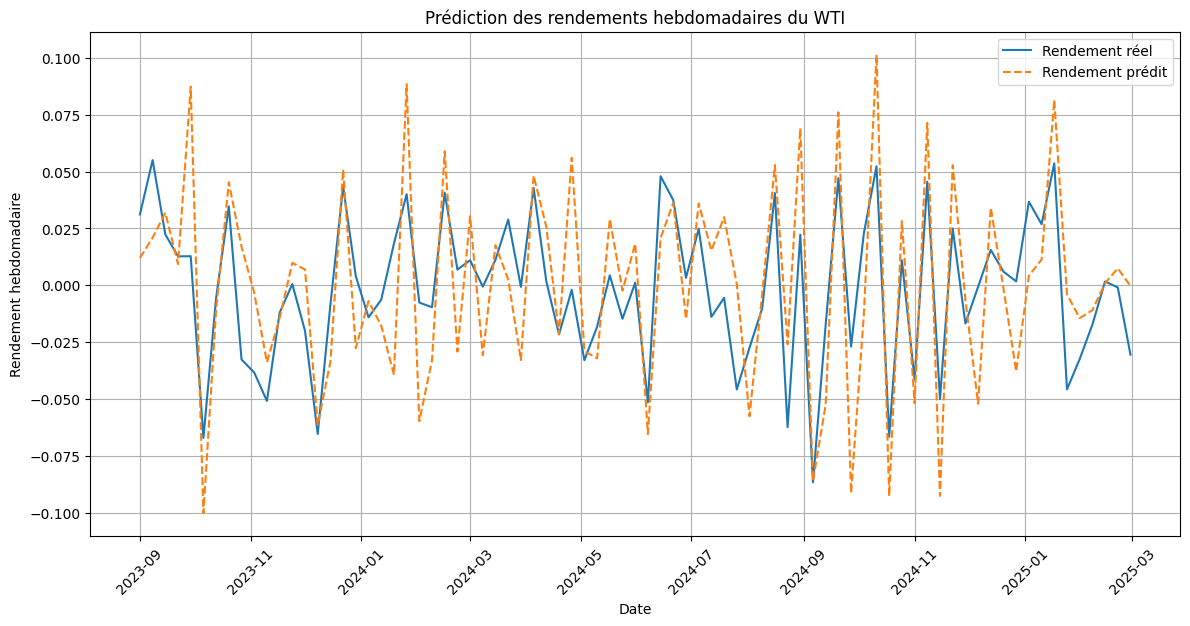

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label="Rendement réel")
plt.plot(dates_test, y_pred, label="Rendement prédit", linestyle='--')

plt.title("Prédiction des rendements hebdomadaires du WTI")
plt.xlabel("Date")
plt.ylabel("Rendement hebdomadaire")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Pour lisibilité des dates
plt.show()

### Interprétation du graphique de prédiction

Le graphique ci-dessus illustre la capacité du modèle de régression linéaire, basé sur les quatre composantes principales issues de l'ACP, à prédire les rendements hebdomadaires du WTI sur le jeu de test.

- On observe que les **tendances générales sont partiellement captées** par le modèle, notamment dans les phases de retournement ou de baisse marquée.
- Cependant, **l'amplitude des variations prédites** est souvent **surestimée** (variabilité plus forte que celle du rendement réel), ce qui reflète une **erreur de calibration** classique des modèles linéaires en finance.
- Malgré cela, le modèle présente un bon **pouvoir explicatif in-sample** (R² ≈ 0.78) et offre une première base pour une prévision quantitative du marché pétrolier.

Ce type de visualisation est essentiel pour **évaluer la stabilité du modèle dans le temps** et son comportement en dehors de l’échantillon d’apprentissage.
